# Develop SMARTS

Just a playground notebook to check some ideas for substructure SMARTS or reactionSMARTS for pattern matching / enumeration in SynFerm libraries

In [1]:
import pathlib
import sys

import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw,rdMolDescriptors,AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.rdChemReactions import ReactionFromSmarts
from rdkit.Chem import ChiralType
from rdkit import SimDivFilters,DataStructs

sys.path.append(str(pathlib.Path().resolve().parents[1]))
from src.util.db_utils import SynFermDatabaseConnection

In [2]:
con = SynFermDatabaseConnection()
res = con.con.execute("SELECT * FROM building_blocks").fetchall()
header = [i[1] for i in con.con.execute("PRAGMA table_info(building_blocks)").fetchall()]
df = pd.DataFrame(res, columns=header)
initiators = df.loc[df["category"] == "I"]
monomers = df.loc[df["category"] == "M"]
terminators = df.loc[df["category"] == "T"]

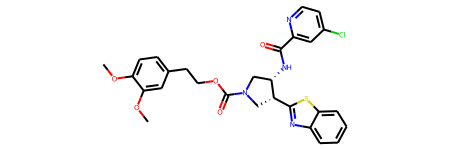

In [3]:
mol = Chem.MolFromSmiles("COc1ccc(CCOC(=O)N2C[C@H](NC(=O)c3cc(Cl)ccn3)[C@H](c3nc4ccccc4s3)C2)cc1OC")
mol

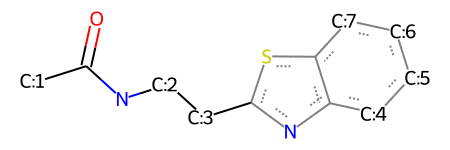

In [4]:
pat = Chem.MolFromSmarts("[#6:1]-[#6](=O)-[NR0]-[#6:2]-[#6:3]-c1nc2[c:4][c:5][c:6][c:7]c2s1")
pat

In [5]:
mol.GetSubstructMatches(pat)

((17, 15, 16, 14, 13, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33),)

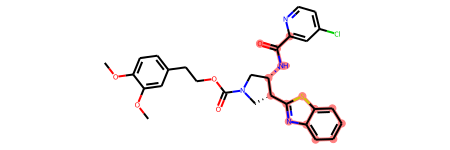

In [6]:
mol

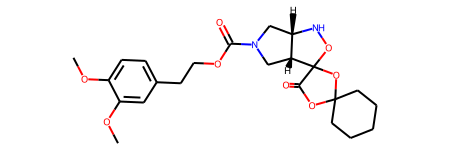

In [7]:
Chem.MolFromSmiles("COc1ccc(CCOC(=O)N2C[C@@H]3NOC4(OC5(CCCCC5)OC4=O)[C@@H]3C2)cc1OC")

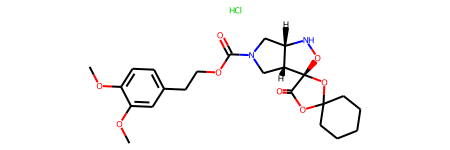

In [8]:
Chem.MolFromSmiles("COc1ccc(CCOC(=O)N2C[C@@H]3NO[C@]4(OC5(CCCCC5)OC4=O)[C@@H]3C2)cc1OC.Cl")

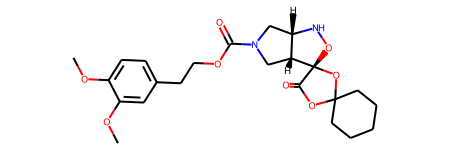

In [9]:
mol = Chem.MolFromSmiles("COc1ccc(CCOC(=O)N2C[C@@H]3NO[C@]4(OC5(CCCCC5)OC4=O)[C@@H]3C2)cc1OC")
mol

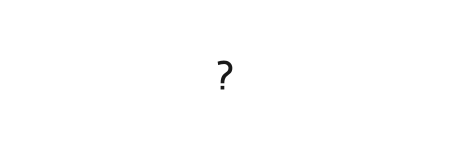

In [10]:
pat = Chem.MolFromSmarts("[$([CR2](O1)(ONC2)(C2)C(=O)OC1)]")  # hits a spiro carbon atom between an isoxazolidine and a 5-membered lactone-ether ring
pat

In [11]:
mol.GetSubstructMatches(pat)

((16,),)

In [12]:
a = mol.GetAtomWithIdx(16)

In [13]:
a.SetChiralTag(ChiralType.CHI_UNSPECIFIED)

In [14]:
Chem.MolToSmiles(mol) == "COc1ccc(CCOC(=O)N2C[C@@H]3NOC4(OC5(CCCCC5)OC4=O)[C@@H]3C2)cc1OC"

True

In [15]:
def remove_monomer_pg_chirality(mol):
    """
    Given a monomer building block, remove only the chiral information 
    for the spiro carbon of the protecting group, leaving the rest unchanged.
    """
    if isinstance(mol, str):
        mol = Chem.MolFromSmiles(mol)
    else:
        mol = Chem.Mol(mol)
    match = mol.GetSubstructMatches(pat)
    assert len(match) == 1
    atom = mol.GetAtomWithIdx(match[0][0])
    atom.SetChiralTag(ChiralType.CHI_UNSPECIFIED)
    return mol

/Users/julian/miniconda3/envs/library-generation/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:241: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


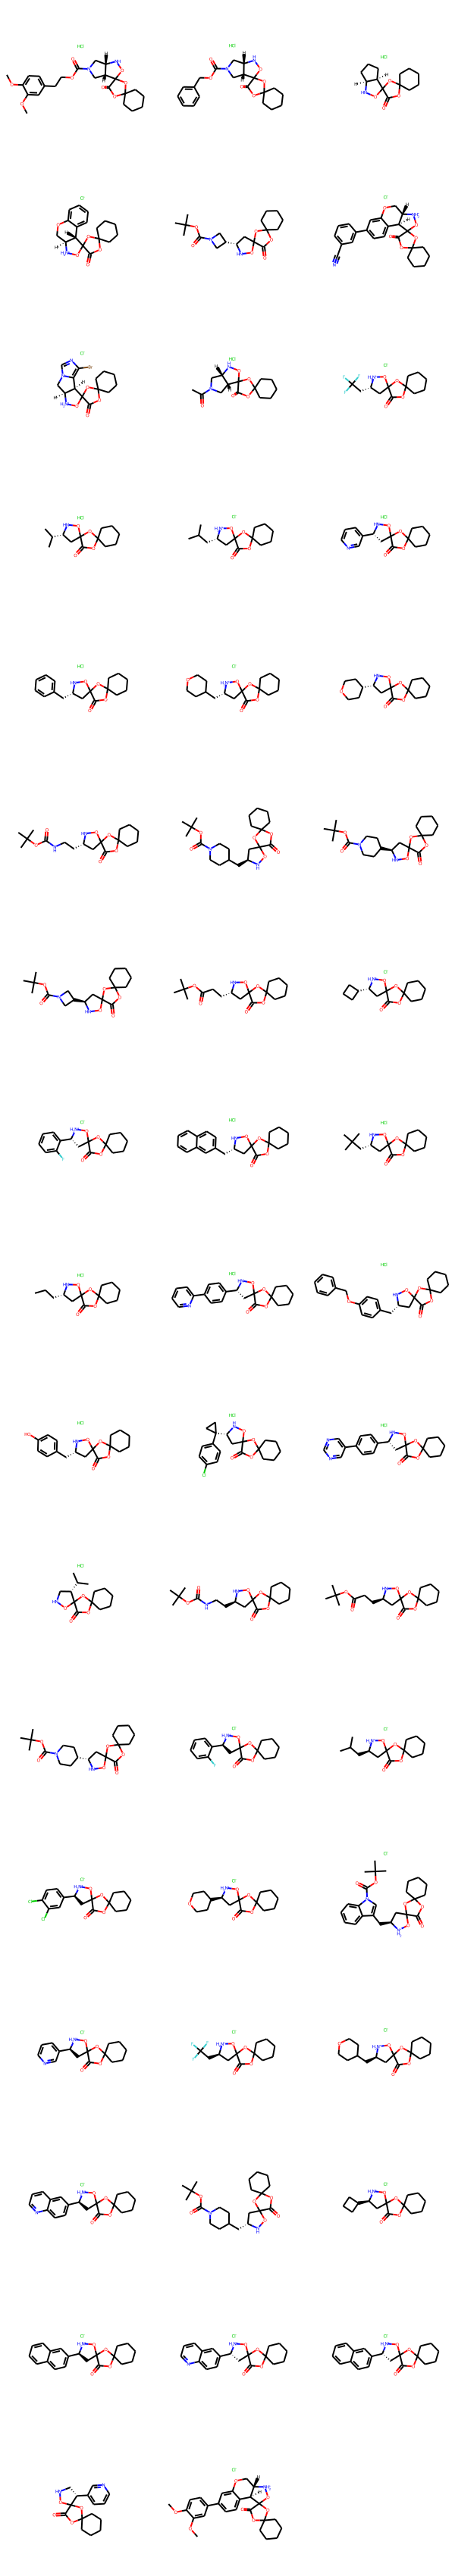

In [16]:
Draw.MolsToGridImage([remove_monomer_pg_chirality(smi) for smi in monomers["SMILES"]])

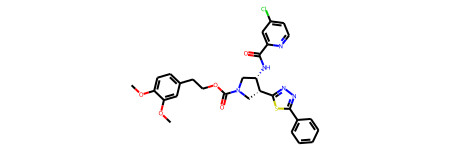

In [17]:
con.get_vl_member(19)

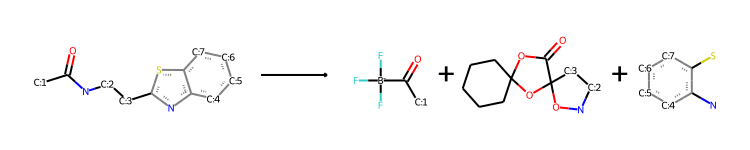

In [18]:
_backwards_rxn_abt = "[#6:1]-C(=O)-N-[C:2]-[C:3]-c1nc2[c:4][c:5][c:6][c:7]c2s1>>F-[B-](-F)(-F)-C(-[#6:1])=O.O=C1-O-C2(-C-C-C-C-C-2)-O-C-1-1-[C:3]-[C:2]-N-O-1.N-c1[c:4][c:5][c:6][c:7]c1-S"
rxn = ReactionFromSmarts(_backwards_rxn_abt)
rxn

In [19]:
res = rxn.RunReactants((con.get_vl_member(18),))[0]
[Chem.SanitizeMol(m) for m in res]

[rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE,
 rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE,
 rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE]

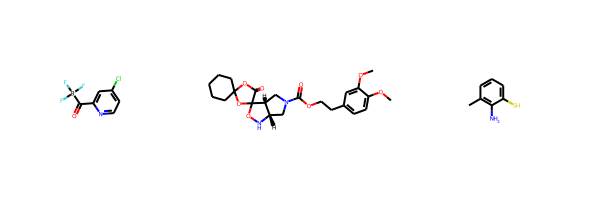

In [20]:
Draw.MolsToGridImage(res)

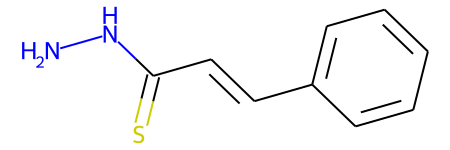

In [21]:
Chem.MolFromSmiles("NNC(=S)/C=C/c1ccccc1")

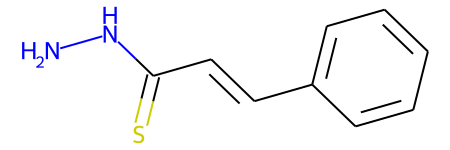

In [22]:
Chem.MolFromSmiles("NNC(=S)C=Cc1ccccc1")

In [23]:
Chem.MolToSmiles(con.get_vl_member(25))

'COc1ccc(CCOC(=O)N2C[C@H](NC(=O)c3cc(Cl)ccn3)[C@H](c3nnc(/C=C/c4ccccc4)s3)C2)cc1OC'

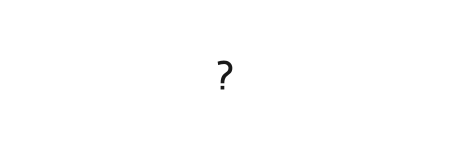

In [24]:
pat

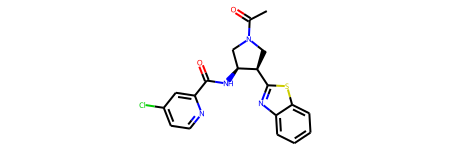

In [25]:
mol = con.get_vl_member(288)
mol.GetSubstructMatches(pat)
mol

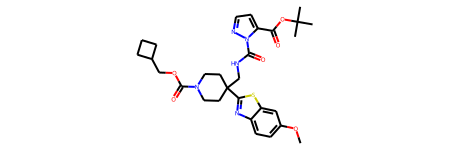

In [26]:
con.get_vl_member(54051)

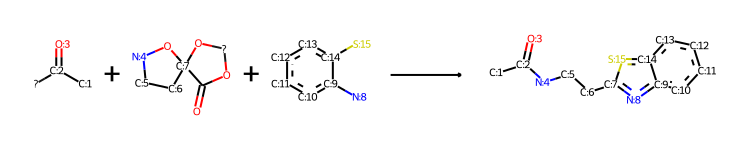

In [27]:
rxn = ReactionFromSmarts(
    "[$(B(-F)(-F)-F)]-[C:2](-[#6:1])=[O:3].O=C1-O-[$(C2CCCCC2)]-O-[C:7]-1-1-[C:6]-[C:5]-[N:4]-O-1.[N:8]-[c:9]1:[c:10]:[c:11]:[c:12]:[c:13]:[c:14]:1-[S:15]>>[#6:1]-[C:2](=[O:3])-[N:4]-[C:5]-[C:6]-[c:7]1:[n:8]:[c:9]2:[c:10]:[c:11]:[c:12]:[c:13]:[c:14]:2:[s:15]:1."
)
rxn

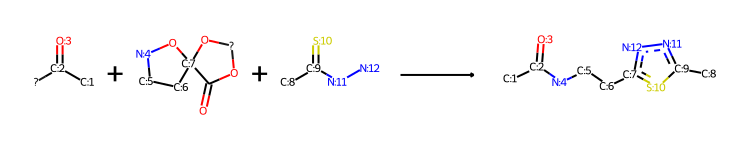

In [28]:
rxn = ReactionFromSmarts(
"[$(B(-F)(-F)-F)]-[C:2](-[#6:1])=[O:3].O=C1-O-[$(C2CCCCC2)]-O-[C:7]-1-1-[C:6]-[C:5]-[N:4]-O-1.[#6:8]-[C:9](=[S:10])-[N:11]-[N:12]>>[#6:8]-[c:9]1:[n:11]:[n:12]:[c:7](-[C:6]-[C:5]-[N:4]-[C:2](-[#6:1])=[O:3]):[s:10]:1."
)
rxn

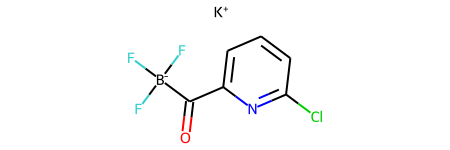

In [29]:
i = Chem.MolFromSmiles(con.get_smiles("I2"))
i

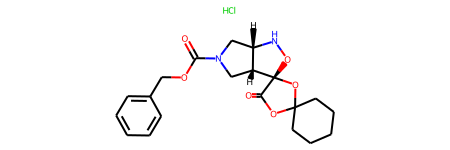

In [30]:
m = Chem.MolFromSmiles(con.get_smiles("M2"))
m

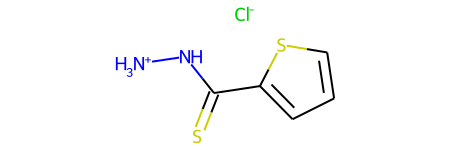

In [31]:
t = Chem.MolFromSmiles(con.get_smiles("T20"))
t

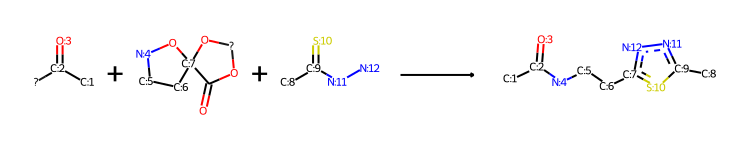

In [32]:
rxn

In [33]:
prods = rxn.RunReactants((i,m,t))

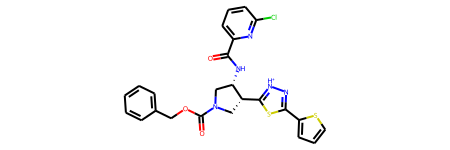

In [34]:
prods[0][0]

In [35]:
prods

((<rdkit.Chem.rdchem.Mol at 0x143a2eac0>,),)

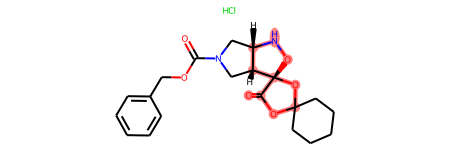

In [36]:
pat = rxn.GetReactantTemplate(1)

m.GetSubstructMatches(pat)
m

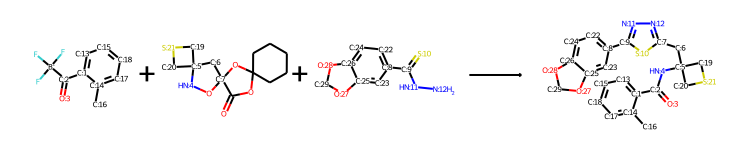

In [37]:
smi = "F[B-](F)(F)[C:2]([c:1]1[cH:13][cH:15][cH:18][cH:17][c:14]1[CH3:16])=[O:3].O=C1OC2(CCCCC2)O[C:7]12O[NH:4][C:5]1([CH2:6]2)[CH2:19][S:21][CH2:20]1.[c:8]1([C:9](=[S:10])[NH:11][NH2:12])[cH:22][cH:24][c:26]2[c:25]([cH:23]1)[O:27][CH2:29][O:28]2>>[c:1]1([C:2](=[O:3])[NH:4][C:5]2([CH2:6][c:7]3[s:10][c:9](-[c:8]4[cH:22][cH:24][c:26]5[c:25]([cH:23]4)[O:27][CH2:29][O:28]5)[n:11][n:12]3)[CH2:19][S:21][CH2:20]2)[cH:13][cH:15][cH:18][cH:17][c:14]1[CH3:16]"

rxn = ReactionFromSmarts(smi, useSmiles=True)
rxn

In [38]:
df = pd.read_csv("../../data/curated_data/synferm_dataset_2023-09-05_40018records.csv")[["product_A_smiles", "reaction_smiles_atom_mapped", "experiment_id"]]

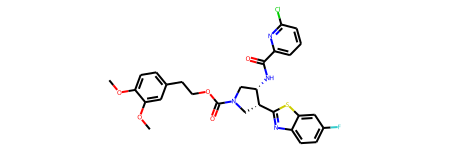

In [39]:
Chem.MolFromSmiles(df.loc[df.experiment_id == "56113", "product_A_smiles"].item())

In [40]:
Chem.MolToSmiles(con.get_vl_member(35080))

'O=C(N[C@@H](Cc1nnc(/C=C/c2ccccc2)s1)CC1CCOCC1)c1cccnc1'

In [429]:
# reactants to product H
_rxn_abt_H = "[$(B(-F)(-F)-F)]-[$(C-[#6])X3:1]=[O:2].O=C1-O-[$(C2CCCCC2)]-O-[C:6]-1-1-[C:5](-[H])-[C:4]-[NH1:3]-O-1.[NH2:7]-[c:8]1:[c:9]:[c:10]:[c:11]:[c:12]:[c:13]:1-[SH1:14]>>[C:4]=[C:5]-[c:6]:1:[n:7]:[c:8]2:[c:9]:[c:10]:[c:11]:[c:12]:[c:13]:2:[s:14]:1"
_rxn_th_H = "[$(B(-F)(-F)-F)]-[$(C-[#6])X3:1]=[O:2].O=C1-O-[$(C2CCCCC2)]-O-[C:6]-1-1-[C:5](-[H])-[C:4]-[NH1:3]-O-1.[C:7](=[S:8])-[NH1:9]-[NH2:10]>>[s:8]:1:[c:7]:[n:9]:[n:10]:[c:6]:1-[C:5]=[C:4]"


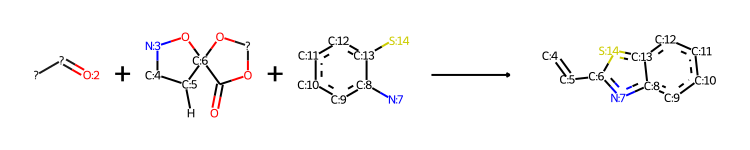

In [474]:
rxn = ReactionFromSmarts(_rxn_abt_H)
rxn

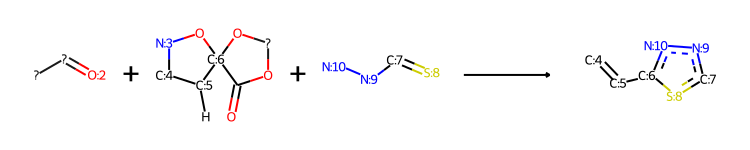

In [431]:
rxn = ReactionFromSmarts(_rxn_th_H)
rxn

In [457]:
initiators.loc[initiators.long == "2-Pyr002"]

,id,long,SMILES,image,category,boc,cbz,tbu,tms,lcms_mass_1,lcms_mass_alt,comment,lcms_formula_1,lcms_formula_alt,reactant_class
0,3,2-Pyr002,O=C(c1cc(Cl)ccn1)[B-](F)(F)F.[K+],/Users/julian/PycharmProjects/library-generati...,I,0,0,0,0,207.99538,None,None,C6H3BClF3NO-,None,KAT_hetarom


In [454]:
monomers.loc[monomers.long == "Fused002"]

,id,long,SMILES,image,category,boc,cbz,tbu,tms,lcms_mass_1,lcms_mass_alt,comment,lcms_formula_1,lcms_formula_alt,reactant_class
78,81,Fused002,COc1ccc(CCOC(=O)N2C[C@@H]3NO[C@]4(OC5(CCCCC5)O...,/Users/julian/PycharmProjects/library-generati...,M,0,0,0,0,462.200216,None,None,C23H30N2O8,None,Mon_fused


In [452]:
terminators.loc[terminators.long == "TerABT001"]

,id,long,SMILES,image,category,boc,cbz,tbu,tms,lcms_mass_1,lcms_mass_alt,comment,lcms_formula_1,lcms_formula_alt,reactant_class
152,155,TerABT001,Nc1ccccc1S,/Users/julian/PycharmProjects/library-generati...,T,0,0,0,0,125.02992,None,None,C6H7NS,None,TerABT


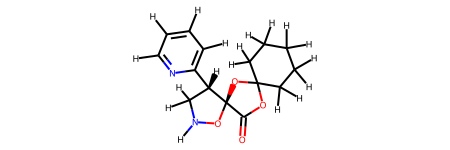

In [435]:
Chem.AddHs(desalt_building_block(Chem.MolFromSmiles(monomers.at[134, "SMILES"])))

In [392]:
terminators.at[78, "SMILES"]

'COc1ccc(CCOC(=O)N2C[C@@H]3NO[C@]4(OC5(CCCCC5)OC4=O)[C@@H]3C2)cc1OC.Cl'

In [466]:
from rdkit.Chem.rdChemReactions import SanitizeRxn

In [475]:
rxn.Initialize()
#SanitizeRxn(rxn)

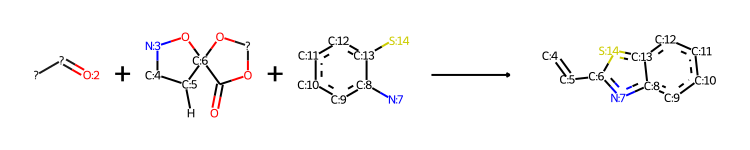

In [476]:
rxn

In [477]:
prods = rxn.RunReactants(
    [desalt_building_block(Chem.MolFromSmiles(initiators.at[3, "SMILES"])), 
     Chem.AddHs(desalt_building_block(Chem.MolFromSmiles(monomers.at[78, "SMILES"]))), 
     desalt_building_block(Chem.MolFromSmiles(terminators.at[152, "SMILES"]))
    ]
)

In [478]:
prods

((<rdkit.Chem.rdchem.Mol at 0x12d908190>,),)

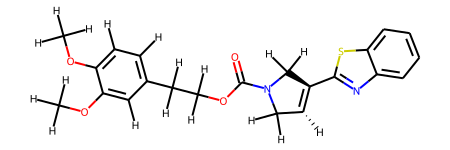

In [479]:
p = prods[0][0]
p

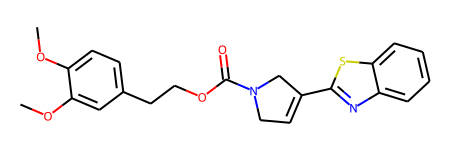

In [480]:
Chem.rdmolops.RemoveAllHs(p)

In [481]:
p = Chem.rdmolops.RemoveHs(p)

In [482]:
Chem.SanitizeMol(p)

rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE

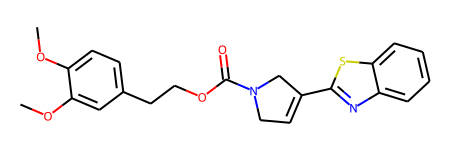

In [483]:
p

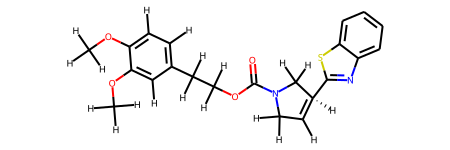

In [465]:
Chem.MolFromSmiles('[H]C1=[C@]([H])(c2nc3ccccc3s2)C([H])([H])N(C(=O)OC([H])([H])C([H])([H])c2c([H])c([H])c(OC([H])([H])[H])c(OC([H])([H])[H])c2[H])C1([H])[H]', sanitize=False)

In [428]:
Chem.MolToSmiles(p)

'CC(C)CC=Cc1nnc(/C=C/c2ccccc2)s1'

In [383]:
p.UpdatePropertyCache()

RDKit ERROR: [16:25:25] Explicit valence for atom # 5 C, 5, is greater than permitted
[16:25:25] Explicit valence for atom # 5 C, 5, is greater than permitted


AtomValenceException: Explicit valence for atom # 5 C, 5, is greater than permitted

In [416]:
p.GetAtomWithIdx(5).GetTotalValence()

4

In [417]:
p.GetAtomWithIdx(5).GetNumExplicitHs()

0

In [390]:
p = Chem.rdmolops.AddHs(p)

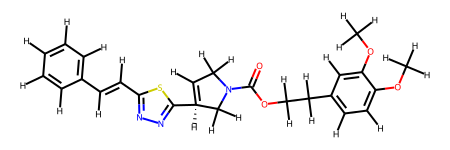

In [391]:
p

In [388]:
p = Chem.rdmolops.RemoveHs(p, sanitize=False, updateExplicitCount=True)

In [366]:
Chem.rdmolops.Cleanup(p)

In [382]:
Chem.SanitizeMol(p)

RDKit ERROR: [16:25:23] Explicit valence for atom # 5 C, 5, is greater than permitted
[16:25:23] Explicit valence for atom # 5 C, 5, is greater than permitted


AtomValenceException: Explicit valence for atom # 5 C, 5, is greater than permitted

In [341]:
a.GetNeighbors()

(<rdkit.Chem.rdchem.Atom at 0x143e24340>,
 <rdkit.Chem.rdchem.Atom at 0x1280578e0>)

In [195]:
Chem.MolToSmiles(Chem.MolFromSmiles("C(=Cc1cccnc1)c1nnc(-c2cccc3[nH]ncc23)s1"))

'C(=Cc1nnc(-c2cccc3[nH]ncc23)s1)c1cccnc1'

In [196]:
Chem.MolToSmiles(Chem.MolFromSmiles("C(=Cc1nnc(-c2cccc3[nH]ncc23)s1)c1cccnc1"))

'C(=Cc1nnc(-c2cccc3[nH]ncc23)s1)c1cccnc1'

In [41]:
from src.library_design.reaction_generator import SFReactionGenerator

In [44]:
rxn_generator = SFReactionGenerator()

RDKit WARNING: [13:46:22] Mismatched potential rlabels: 2 unmapped reactant dummy atom rlabels,0 unmappped product dummy atom rlabels
RDKit WARNING: [13:46:22] Mismatched potential rlabels: 2 unmapped reactant dummy atom rlabels,0 unmappped product dummy atom rlabels
[13:46:22] Mismatched potential rlabels: 2 unmapped reactant dummy atom rlabels,0 unmappped product dummy atom rlabels
[13:46:22] Mismatched potential rlabels: 2 unmapped reactant dummy atom rlabels,0 unmappped product dummy atom rlabels


In [46]:
[Chem.MolToSmiles(smi) for smi in rxn_generator.generate_reactants(Chem.MolToSmiles(con.get_vl_member(35080)))]

['O=C(c1cccnc1)[B-](F)(F)F',
 'O=C1OC2(CCCCC2)OC12C[C@@H](CC1CCOCC1)NO2',
 'NNC(=S)C=Cc1ccccc1']

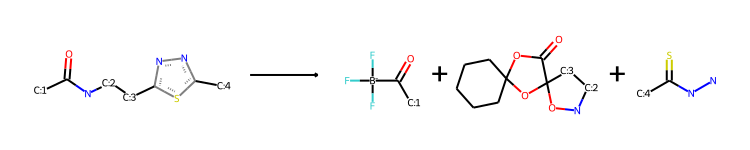

In [48]:
rxn_generator.backwards_reactions["th"]

In [87]:
_backwards_rxn_abt = "[$(C-[#6]):1](=O)-[NR0]-[C:2]-[C:3]-c1nc2[c:4][c:5][c:6][c:7]c2s1>>F-[B-](-F)(-F)-[C:1]=O.O=C1-O-C2(-C-C-C-C-C-2)-O-C-1-1-[C:3]-[C:2]-N-O1.N-c1:[c:4]:[c:5]:[c:6]:[c:7]:c:1-S"


In [88]:
_backwards_rxn_th = "[c:4]1nnc(-[C:3]-[C:2]-[NR0]-[$(C-[#6]):1]=O)s1>>F-[B-](-F)(-F)-[C:1]=O.O=C1-O-C2(-C-C-C-C-C-2)-O-C-1-1-[C:3]-[C:2]-N-O1.[C:4](=S)-N-N"


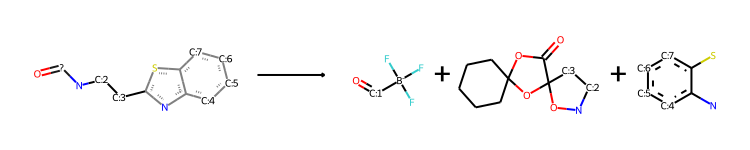

In [89]:
rxn = ReactionFromSmarts(_backwards_rxn_abt)
rxn

In [67]:
prods = rxn.RunReactants((con.get_vl_member(35080),))

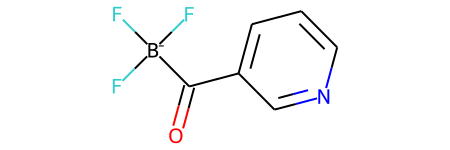

In [70]:
prods[0][0]

In [246]:
_rxn_abt = "[$(B(-F)(-F)-F)]-[$(C-[#6])X3:1]=[O:2].O=C1-O-[$(C2CCCCC2)]-O-[C:6]-1-1-[C:5]-[C:4]-[NH1:3]-O-1.[NH2:7]-[c:8]1:[c:9]:[c:10]:[c:11]:[c:12]:[c:13]:1-[SH1:14]>>[C:1](=[O:2])-[N:3]-[C:4]-[C:5]-[c:6]1:[n:7]:[c:8]2:[c:9]:[c:10]:[c:11]:[c:12]:[c:13]:2:[s:14]:1."
rxn = ReactionFromSmarts(_rxn_abt)

In [228]:
_rxn_th = "[$(B(-F)(-F)-F)]-[$(C-[#6])X3:1]=[O:2].O=C1-O-[$(C2CCCCC2)]-O-[C:6]-1-1-[C:5]-[C:4]-[NH1:3]-O-1.[C:7](=[S:8])-[NH1:9]-[NH2:10]>>[c:7]1:[n:9]:[n:10]:[c:6](-[C:5]-[C:4]-[N:3]-[C:1]=[O:2]):[s:8]:1."
rxn = ReactionFromSmarts(_rxn_th)

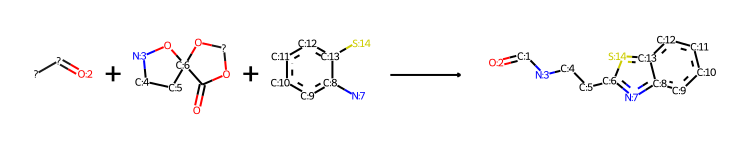

In [247]:
rxn

In [104]:
from src.util.rdkit_util import desalt_building_block

In [231]:
for atom in rxn.GetReactantTemplate(0).GetAtoms():
    print(atom.GetSymbol())

*
*
O


In [232]:
rxn.Initialize()

In [233]:
Chem.rdChemReactions.SanitizeRxn(rxn)

RDKit WARNING: [15:27:49] Mismatched potential rlabels: 3 unmapped reactant dummy atom rlabels,0 unmappped product dummy atom rlabels
RDKit WARNING: [15:27:49] Could not find RLabel mapping for atom: 1 in template: 0
[15:27:49] Mismatched potential rlabels: 3 unmapped reactant dummy atom rlabels,0 unmappped product dummy atom rlabels
[15:27:49] Could not find RLabel mapping for atom: 1 in template: 0


rdkit.Chem.rdChemReactions.SanitizeFlags.SANITIZE_NONE

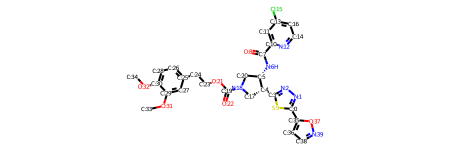

In [234]:
# Prepare atom indices for drawing
for i, atom in enumerate(mol.GetAtoms()):
    atom.SetProp("molAtomMapNumber", str(atom.GetIdx()))
mol

In [235]:
prods = rxn.RunReactants(
    [desalt_building_block(Chem.MolFromSmiles(initiators.at[0, "SMILES"])), 
     desalt_building_block(Chem.MolFromSmiles(monomers.at[78, "SMILES"])), 
     desalt_building_block(Chem.MolFromSmiles(terminators.at[172, "SMILES"]))
    ]
)

In [236]:
mol = prods[0][0]
Chem.SanitizeMol(mol)

rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE

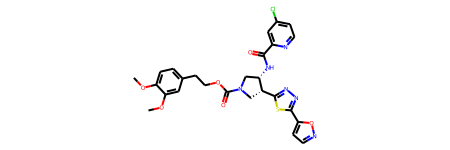

In [237]:
mol

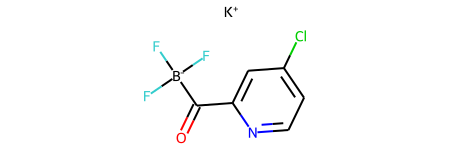

In [153]:
Chem.MolFromSmiles(initiators.at[0, "SMILES"])

In [154]:
terminators

,id,long,SMILES,image,category,boc,cbz,tbu,tms,lcms_mass_1,lcms_mass_alt,comment,lcms_formula_1,lcms_formula_alt,reactant_class
152,155,TerABT001,Nc1ccccc1S,/Users/julian/PycharmProjects/library-generati...,T,0,0,0,0,125.029920,None,None,C6H7NS,None,TerABT
153,156,TerABT004,Nc1ccc(F)cc1S,/Users/julian/PycharmProjects/library-generati...,T,0,0,0,0,143.020498,None,None,C6H6FNS,None,TerABT
154,157,TerABT005,Cc1ccc(N)c(S)c1,/Users/julian/PycharmProjects/library-generati...,T,0,0,0,0,139.045570,None,None,C7H9NS,None,TerABT
155,158,TerABT006,Cc1cc(N)c(S)cc1C,/Users/julian/PycharmProjects/library-generati...,T,0,0,0,0,153.061220,None,None,C8H11NS,None,TerABT
156,159,TerABT007,Nc1cc(Br)ccc1S,/Users/julian/PycharmProjects/library-generati...,T,0,0,0,0,202.940432,None,None,C6H6BrNS,None,TerABT
157,160,TerABT008,Nc1ccc(OC(F)(F)F)cc1S,/Users/julian/PycharmProjects/library-generati...,T,0,0,0,0,209.012219,None,None,C7H6F3NOS,None,TerABT
158,161,TerABT009,Cc1ccc(S)c(N)c1,/Users/julian/PycharmProjects/library-generati...,T,0,0,0,0,139.045570,None,None,C7H9NS,None,TerABT
159,162,TerABT010,Nc1c(S)ccc2ccccc12,/Users/julian/PycharmProjects/library-generati...,T,0,0,0,0,175.045570,None,None,C10H9NS,None,TerABT
160,163,TerABT011,CS(=O)(=O)c1ccc(N)c(S)c1,/Users/julian/PycharmProjects/library-generati...,T,0,0,0,0,203.007471,None,None,C7H9NO2S2,None,TerABT
161,164,TerABT012,Nc1cc(Cl)ccc1S,/Users/julian/PycharmProjects/library-generati...,T,0,0,0,0,158.990948,None,None,C6H6ClNS,None,TerABT


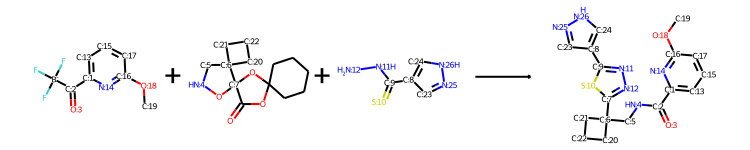

In [242]:
ReactionFromSmarts(
    "F[B-](F)(F)[C:2]([c:1]1[cH:13][cH:15][cH:17][c:16]([O:18][CH3:19])[n:14]1)=[O:3].O=C1OC2(CCCCC2)O[C:7]12O[NH:4][CH2:5][C:6]21[CH2:20][CH2:22][CH2:21]1.[c:8]1([C:9](=[S:10])[NH:11][NH2:12])[cH:23][n:25][nH:26][cH:24]1>>[c:1]1([C:2](=[O:3])[NH:4][CH2:5][C:6]2([c:7]3[s:10][c:9](-[c:8]4[cH:23][n:25][nH:26][cH:24]4)[n:11][n:12]3)[CH2:20][CH2:22][CH2:21]2)[cH:13][cH:15][cH:17][c:16]([O:18][CH3:19])[n:14]1",
    useSmiles=True
)

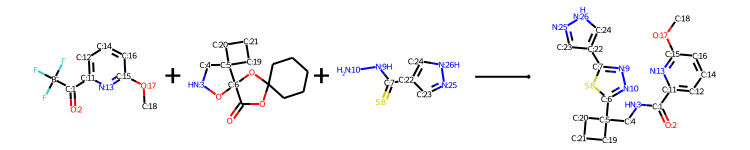

In [243]:
ReactionFromSmarts(
    "F[B-](F)(F)[C:1](=[O:2])[c:11]1[cH:12][cH:14][cH:16][c:15]([O:17][CH3:18])[n:13]1.O=C1OC2(CCCCC2)O[C:6]12O[NH:3][CH2:4][C:5]21[CH2:19][CH2:21][CH2:20]1.[C:7](=[S:8])([NH:9][NH2:10])[c:22]1[cH:23][n:25][nH:26][cH:24]1>>[C:1](=[O:2])([NH:3][CH2:4][C:5]1([c:6]2[s:8][c:7](-[c:22]3[cH:23][n:25][nH:26][cH:24]3)[n:9][n:10]2)[CH2:19][CH2:21][CH2:20]1)[c:11]1[cH:12][cH:14][cH:16][c:15]([O:17][CH3:18])[n:13]1",
    useSmiles=True
)